In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from livelossplot import PlotLosses


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


Change from a direct loading into memory to using a dataloader. The dataloader prevents this from happening, presenting an "on-demand" memory efficient loading of data. It is also well integrated into PyTorch, which simplifies the use with the models.

In our data loader here, we define both a window size (the length of the sequence), prediction size (the number of elements to be predicted) and then batch size. The output will be both X ("training") tensors, which will be of size batch size, Window size - prediction size, 1, 366, 366, and Y, which will be of size batch size, Window size - prediction size, 1, 366, 366. The window will slide linearly, in the sense that there is overlap in all the elements except the first one and last one between subsequent sequences.

In [2]:
class ImageSequenceDataset(Dataset):
    def __init__(self, directory, transform=None, window_size=10, prediction_size=3):
        self.directory = directory
        self.transform = transform
        self.window_size = window_size
        self.prediction_size = prediction_size

        # List of sorted filenames
        self.filenames = sorted([f for f in os.listdir(directory) if f.endswith('.jpg')])
        
        # Total number of sequences that can be generated given the window and prediction sizes
        self.num_sequences = len(self.filenames) - window_size + 1

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        sequence_images = []

        # Calculate start and end index of the sequence
        start_idx = idx
        end_idx = idx + self.window_size

        # Load and transform each image in the sequence
        for i in range(start_idx, end_idx):
            image_path = os.path.join(self.directory, self.filenames[i])
            image = Image.open(image_path).convert('L')
            if self.transform:
                image = self.transform(image)
            sequence_images.append(image)

        # Convert list of images to tensor
        sequence_tensor = torch.stack(sequence_images)

        # Split the sequence tensor into X (input) and y (target)
        X = sequence_tensor[:self.window_size - self.prediction_size]
        y = sequence_tensor[self.window_size - self.prediction_size:]

        return X, y
    
directory = 'Selected_Storms_curated/gme'

window_size = 10
prediction_size = 3

transform = transforms.Compose([
    transforms.Resize((366, 366)),
    transforms.ToTensor(),
])


In [3]:
class ConvLSTMModel(nn.Module):
    def __init__(self, prediction_shape):
        super(ConvLSTMModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.lstm = nn.LSTM(input_size=128 * 45 * 45, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(256, np.prod(prediction_shape))
        self.prediction_shape = prediction_shape

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape
        c_in = x.view(batch_size * seq_len, C, H, W)
        c_out = self.conv_layers(c_in)
        r_in = c_out.view(batch_size, seq_len, -1)
        r_out, _ = self.lstm(r_in)
        r_out2 = self.fc(r_out[:, -1, :])
        return r_out2.view(-1, *self.prediction_shape) 
    
prediction_shape=(prediction_size, 366, 366, 1)
model = ConvLSTMModel(prediction_shape=prediction_shape).to(device)
print(model)

ConvLSTMModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(259200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=401868, bias=True)
)


In [4]:
# Initialize the dataset
dataset = ImageSequenceDataset(
    directory='Selected_Storms_curated/gme',
    transform=transform,  # Assuming transform is defined as before
    window_size=10,
    prediction_size=3
)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

first_batch = next(iter(dataloader))
X_first, y_first = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first.shape}')
print(f'Shape of y in the first batch: {y_first.shape}')

Shape of X in the first batch: torch.Size([2, 7, 1, 366, 366])
Shape of y in the first batch: torch.Size([2, 3, 1, 366, 366])


In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

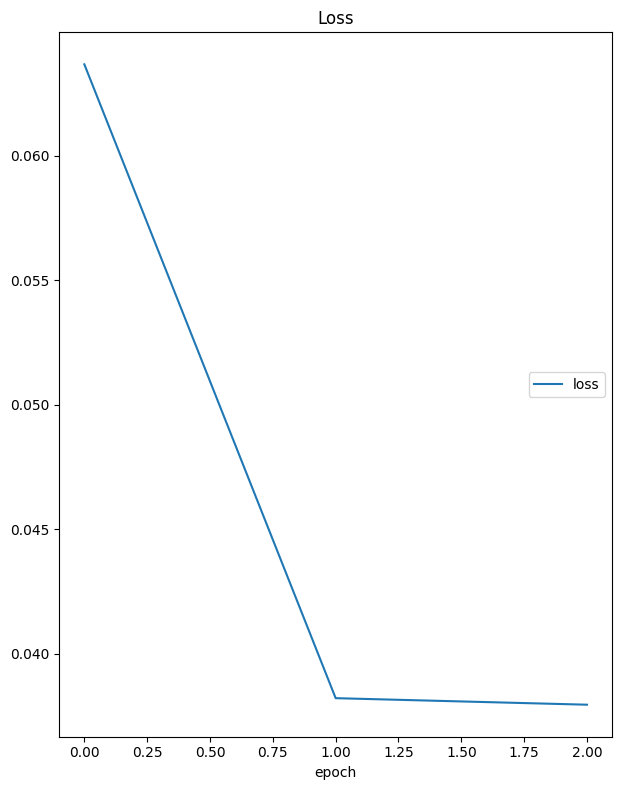

Loss
	loss             	 (min:    0.038, max:    0.064, cur:    0.038)
Epoch 3, Loss: 0.0379501043073833


In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.view(-1, *prediction_shape))  # Adjust the shape if necessary
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def train(model, dataloader, criterion, optimizer, epochs=10, device=device, plot_losses=False):
    liveloss = PlotLosses() if plot_losses else None
    
    for epoch in range(epochs):
        logs = {}
        avg_loss = train_epoch(model, dataloader, criterion, optimizer, device)
        
        # Log the average loss for this epoch
        logs['loss'] = avg_loss
        
        # Update the live plot with the latest logs
        if plot_losses:
            liveloss.update(logs)
            liveloss.send()
        
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

train(model, dataloader, criterion, optimizer, epochs=3, plot_losses=True)

In [5]:
# save model
torch.save(model.state_dict(), 'model.pt')


In [8]:

# load model
#model = ConvLSTMModel(prediction_shape=prediction_shape).to(device)
#model.load_state_dict(torch.load('model.pt'))
#model.eval()



ConvLSTMModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(259200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=401868, bias=True)
)

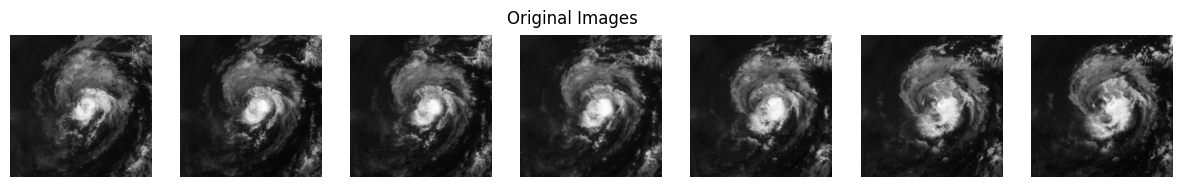

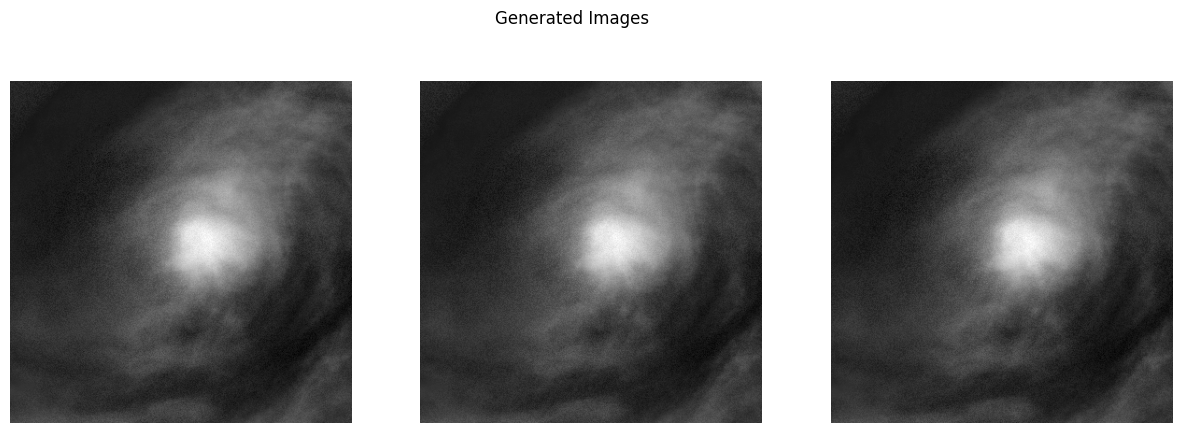

(1, 3, 366, 366)
(1, 3, 366, 366)
(1, 3, 366, 366)


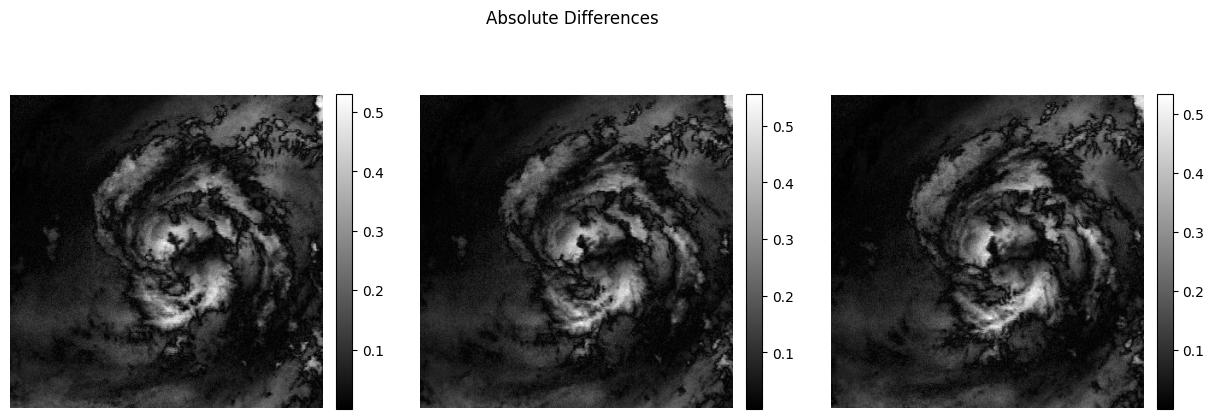

In [8]:

def generate_images(model, input_sequence, num_images=3):
    model.eval()
    with torch.no_grad():
        input_sequence = input_sequence.to(device)
        predictions = model(input_sequence)
        # Assume that the model outputs a flattened image sequence, which needs to be reshaped to match the dimensions of the image.
        predictions = predictions.view(-1, num_images, 366, 366, 1)  # Adjust to the shape of the predicted image
        #reverse_normalize(predictions)
        return predictions.cpu().numpy()  

for X_batch, y_batch in dataloader:
    pass  # Simply iterate to the end

# The last batch is now contained in X_batch and y_batch
last_sequence = X_batch[-1].unsqueeze(0)  

# Generate new images from the last sequence
new_images = generate_images(model, last_sequence, num_images=prediction_size)

# Function to show images remains the same
def show_images(images, title='Images', figsize=(15, 5), show_colorbar=False):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:  # If there's only one image
        axes = [axes]
    for img, ax in zip(images, axes):
        im = ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove singleton dimensions
        ax.axis('off')
        if show_colorbar:
            fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
            # Adjust the fraction and pad to change the size and spacing of the colorbar if needed
    plt.suptitle(title)
    plt.show()

# Show the original images from the last input sequence
original_images = last_sequence.squeeze(0).cpu().numpy()  # Remove batch dimension for plotting
show_images([original_images[i] for i in range(original_images.shape[0])], title='Original Images', figsize=(15, 2))

# Display the generated images
generated_images = new_images.squeeze(0)  # Remove batch dimension for plotting
show_images([generated_images[i] for i in range(generated_images.shape[0])], title='Generated Images', figsize=(15, 5))

real_images = y_batch[-1].to(device).unsqueeze(0)  # Get the last sequence of real images and add batch dimension

# Since new_images is a numpy array, convert real_images to numpy for comparison
real_images_np = real_images.cpu().numpy()
new_images_squeezed = np.squeeze(new_images, axis=-1)  # Removes the last dimension from new_images
real_images_squeezed = np.squeeze(real_images_np, axis=2)  # Removes the third dimension from real_images_np

# Ensure the shapes are now compatible for subtraction
print(new_images_squeezed.shape)  # Should be (1, 3, 366, 366)
print(real_images_squeezed.shape)  # Should be (1, 3, 366, 366)

# Calculate the absolute differences with the adjusted arrays
absolute_differences = np.abs(new_images_squeezed - real_images_squeezed)

# Check the shape of absolute_differences
print(absolute_differences.shape)  # Should be (1, 3, 366, 366)

# Display the absolute differences
show_images([absolute_differences[0, i] for i in range(absolute_differences.shape[1])], title='Absolute Differences', figsize=(15, 5), show_colorbar=True)
